Prepared by

*Asif Newaz*

*Lecturer, EEE, IUT*

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Data

In [2]:
 !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/catsdogs.zip

--2024-03-05 18:43:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.207, 142.250.159.207, 142.251.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/catsdogs.zip’

/content/catsdogs.z 100%[===================>]  65.43M   151MB/s    in 0.4s    

2024-03-05 18:43:04 (151 MB/s) - ‘/content/catsdogs.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile
with zipfile.ZipFile('catsdogs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
base_dir = '/content/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

**Data Visualization**

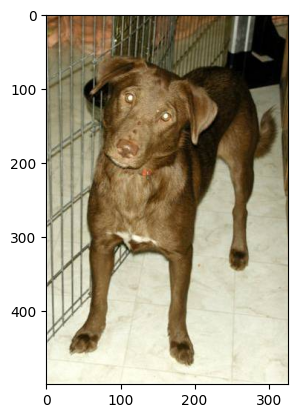

In [4]:
path = '/content/cats_and_dogs_filtered/train/dogs/dog.1.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

In [5]:
img.size

(327, 499)

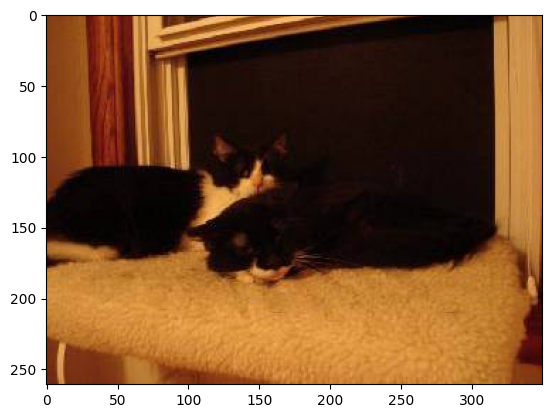

In [6]:
path = '/content/cats_and_dogs_filtered/train/cats/cat.114.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

In [7]:
img.size

(350, 261)

See, different images are of different sizes.

**Dataset size**

In [8]:
print(train_dir)

/content/cats_and_dogs_filtered/train


In [9]:
len('/content/cats_and_dogs_filtered/train/cats')
# this will show number of characters in the string. we want to check number of images in that directory.

42

In [10]:
path = "/content/cats_and_dogs_filtered/train/cats"
fileList=os.listdir(path)
print(len(fileList))

1000


So, there are in total 1000+1000=2000 images for training (a subset of the original data).

In [11]:
path = "/content/cats_and_dogs_filtered/validation/dogs"
fileList=os.listdir(path)
print(len(fileList))

500


Total 1000 images for testing.

# Data Preprocessing

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224))
val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(224,224))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Data Augmentation**

ImageDataGenerator is deprecated in the latest version of TensorFlow. Another way to perform data augmentation is shown below -

https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

In [13]:
data_augmentation = tf.keras.Sequential(
    [       tf.keras.layers.experimental.preprocessing.RandomFlip(),
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.3,0.3)),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.3)
    ]
)

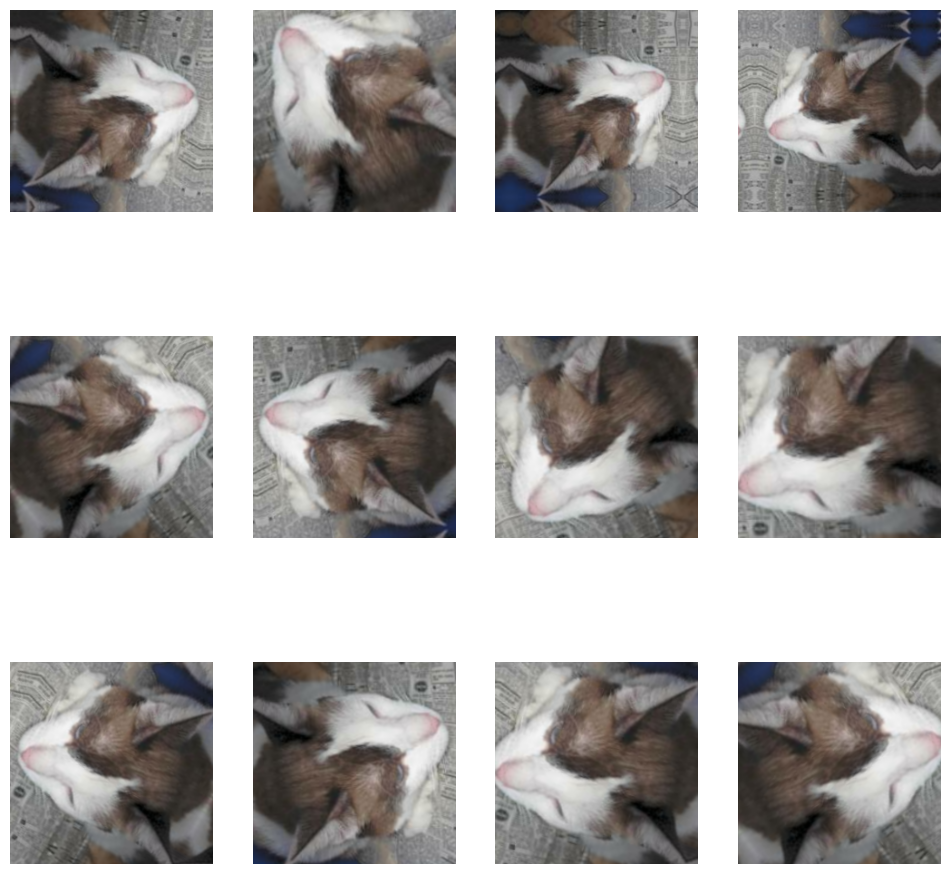

In [14]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

# Model (version-01)

In [47]:
model_v7 = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding= 'same', activation="relu",input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), padding= 'same',  activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
   # tf.keras.layers.Dense(1, activation="sigmoid")
]
)

In [48]:
model_v7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                      

In [49]:
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented_data= data_augmentation(inputs)
x= model_v7(augmented_data)
output= tf.keras.layers.Dense(1, activation="sigmoid") (x)

model= tf.keras.Model(inputs, output)

In [50]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
history = model.fit(training_set,
                          epochs=50,
                          validation_data= val_dataset,
                          callbacks=early_stop)

Epoch 1/50
63/63 [==============================] - 6s 44ms/step - loss: 0.7414 - accuracy: 0.5690 - val_loss: 1.1088 - val_accuracy: 0.5150
Epoch 2/50
63/63 [==============================] - 3s 41ms/step - loss: 0.6915 - accuracy: 0.5885 - val_loss: 1.0304 - val_accuracy: 0.5240
Epoch 3/50
63/63 [==============================] - 3s 41ms/step - loss: 0.6774 - accuracy: 0.6280 - val_loss: 0.7963 - val_accuracy: 0.5380
Epoch 4/50
63/63 [==============================] - 3s 41ms/step - loss: 0.6602 - accuracy: 0.6225 - val_loss: 0.6958 - val_accuracy: 0.6090
Epoch 5/50
63/63 [==============================] - 3s 42ms/step - loss: 0.6320 - accuracy: 0.6540 - val_loss: 0.6556 - val_accuracy: 0.6130
Epoch 6/50
63/63 [==============================] - 3s 41ms/step - loss: 0.6311 - accuracy: 0.6555 - val_loss: 0.6465 - val_accuracy: 0.6530
Epoch 7/50
63/63 [==============================] - 3s 41ms/step - loss: 0.6069 - accuracy: 0.6625 - val_loss: 0.6047 - val_accuracy: 0.6690
Epoch 8/50
63

In [53]:
df = pd.DataFrame(history.history)
df.tail()

,loss,accuracy,val_loss,val_accuracy
17,0.540753,0.7320,0.600323,0.679
18,0.503855,0.7535,0.654088,0.635
19,0.513394,0.7635,0.802267,0.628
20,0.525312,0.7425,0.696429,0.632
21,0.526789,0.7415,0.970055,0.532


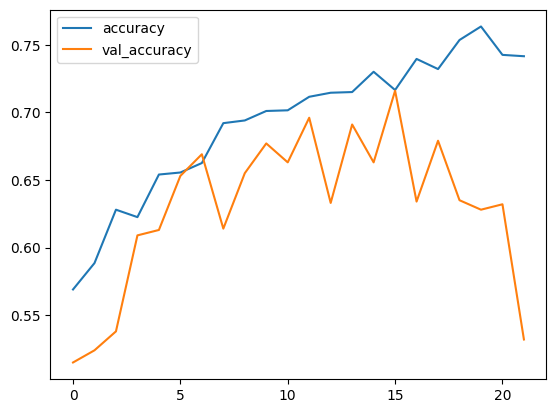

In [54]:
df[["accuracy","val_accuracy"]].plot();

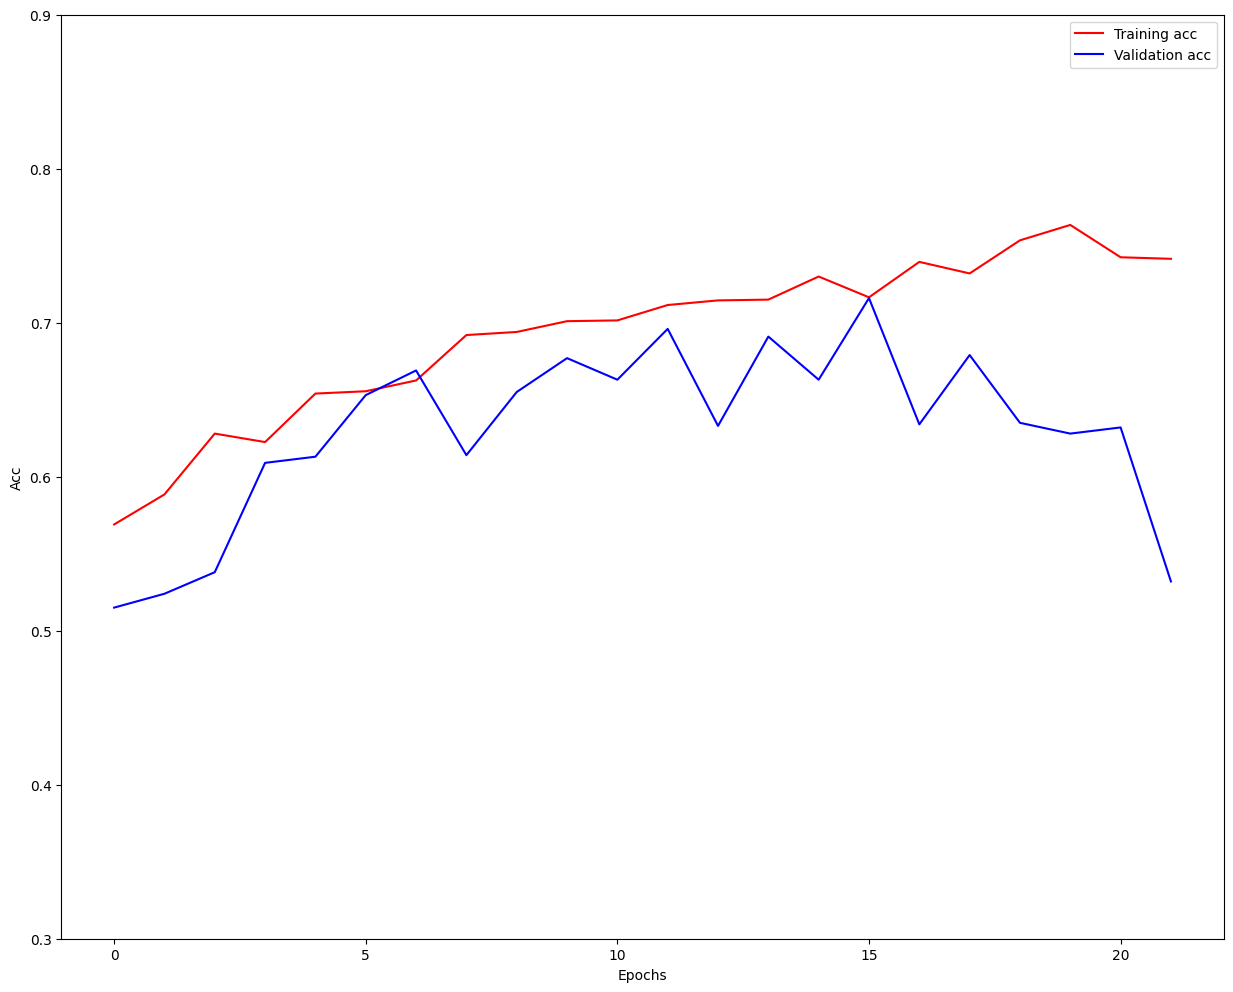

In [55]:
train_acc = df["accuracy"]
val_acc = df["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 0.9])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

As we can see, training and validation performance is closer. So, less overfitting (owing to data augmentation and other factors). However, the performance accuracy is low - only 60% (due to limited data - only 2000 images).

# Transfer Learning

There are three different ways we can make use of a pre-trained model:


*   Direct prediction
*   Feature extraction
*   Fine tuning

A pre-trained model like Inception can be directly used to predict 1000 different categories (on which the model was originally trained on). The code is available here - https://github.com/newaz-aa/CNN/blob/main/03_Using_Pre_trained_CNNs.ipynb

We can also use a pre-trained model as a feature extractor (using the original weights, without training it in the new dataset). For this purpose, we only use the top part of the network, discarding the bottom portion (Adding new layers) which is specific to dataset on which the model was originally trained on.  

We can also retrain the base model and update its weights to proeprly fit it into the new dataset. We can retrain all the weights or some of them.   

# Pretrained model as feature extractor

In [56]:
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(224,224, 3),
    include_top=False)

In [58]:
base_model.trainable = False

In [59]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

No trainable parameters in the base model.

In [60]:
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented_data= data_augmentation(inputs)

In [61]:
# We need to preprocess the input images according to model requirement.
x= tf.keras.applications.vgg16.preprocess_input(augmented_data)

In [62]:
# We add ANN after the base model.

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

In [63]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0   

In [64]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:
history_v2 = model.fit(training_set,
                          epochs=40,
                          validation_data= val_dataset,
                         )

Epoch 1/40
63/63 [==============================] - 6s 69ms/step - loss: 7.6923 - accuracy: 0.4790 - val_loss: 7.5823 - val_accuracy: 0.5010
Epoch 2/40
63/63 [==============================] - 4s 65ms/step - loss: 7.3829 - accuracy: 0.5060 - val_loss: 7.0849 - val_accuracy: 0.5270
Epoch 3/40
63/63 [==============================] - 4s 65ms/step - loss: 6.5759 - accuracy: 0.5515 - val_loss: 4.3257 - val_accuracy: 0.7050
Epoch 4/40
63/63 [==============================] - 4s 65ms/step - loss: 4.7951 - accuracy: 0.6575 - val_loss: 1.7634 - val_accuracy: 0.8740
Epoch 5/40
63/63 [==============================] - 4s 65ms/step - loss: 4.3628 - accuracy: 0.6910 - val_loss: 1.4502 - val_accuracy: 0.8890
Epoch 6/40
63/63 [==============================] - 4s 65ms/step - loss: 4.3414 - accuracy: 0.6940 - val_loss: 3.1259 - val_accuracy: 0.7840
Epoch 7/40
63/63 [==============================] - 4s 65ms/step - loss: 4.1265 - accuracy: 0.7165 - val_loss: 1.9502 - val_accuracy: 0.8640
Epoch 8/40
63

In [66]:
df = pd.DataFrame(history_v2.history)
df.tail(10)

,loss,accuracy,val_loss,val_accuracy
30,7.402495,0.5115,6.300311,0.578
31,7.217530,0.5240,5.844475,0.604
32,5.749846,0.6095,1.132174,0.918
33,2.762314,0.8025,0.887164,0.937
34,2.517286,0.8240,0.889503,0.937
35,2.594400,0.8200,0.829140,0.940
36,4.053072,0.7255,2.404418,0.839
37,4.025177,0.7260,1.622061,0.894
38,2.798515,0.8055,0.892384,0.936
39,2.609489,0.8210,0.764079,0.945


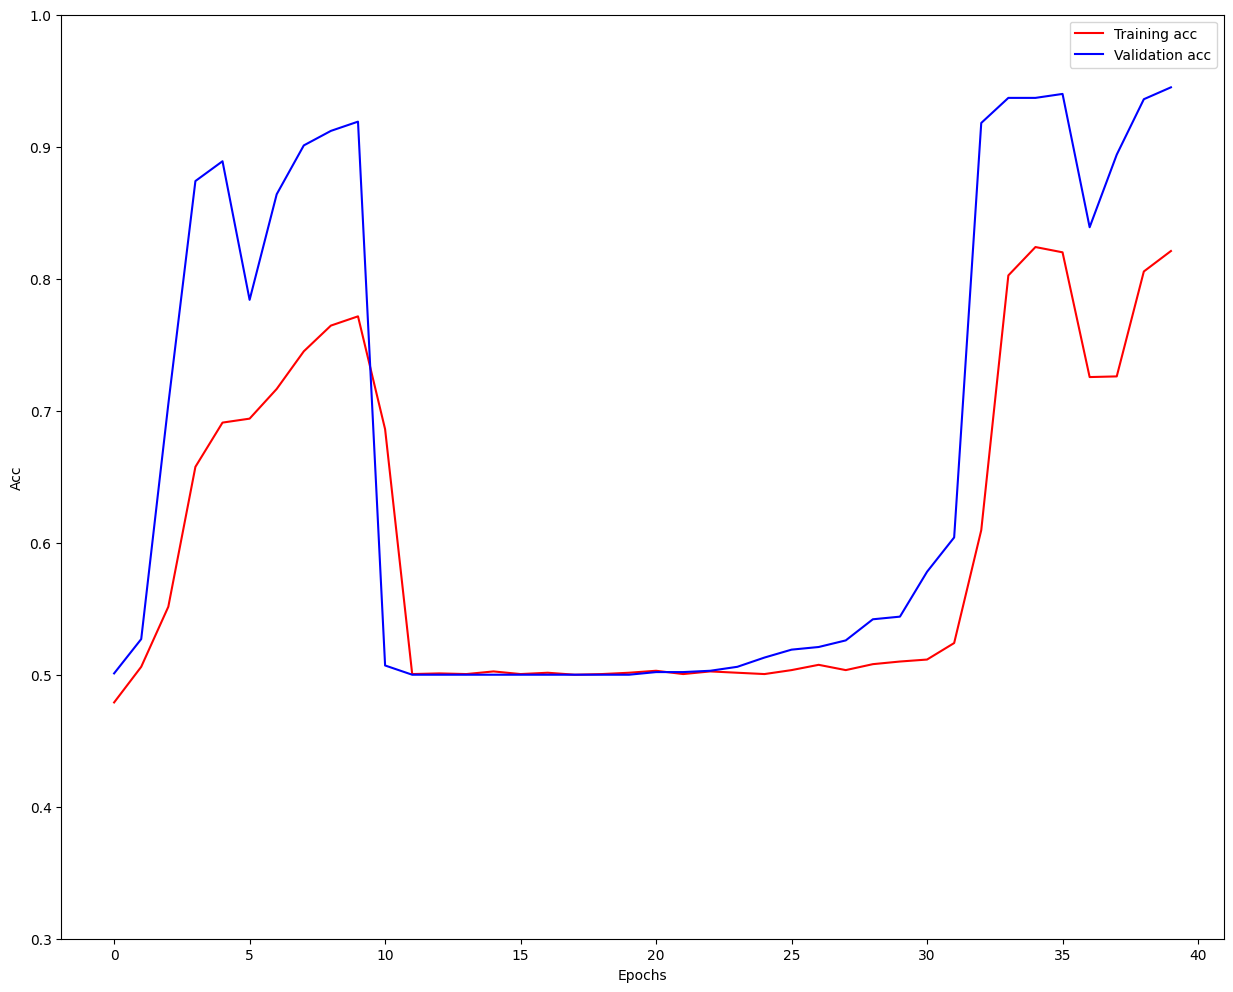

In [67]:
train_acc = df["accuracy"]
val_acc = df["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

Some key observations -

*   validation accuracy is greater than training accuracy. This is due to the data augmentation in the training phase.
*   Most of the weights are directly from the ImageNet dataset (which have cats and dogs images). Therefore, quite a good improvement in performance (90% accuracy).

*   In the middle of training phase, model was stuck for quite some time in some bad search space.





# Fine Tuning

In [79]:
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(224,224, 3),
    include_top=False)

In [80]:
base_model.trainable = True

In [81]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [82]:
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented_data= data_augmentation(inputs)
x= tf.keras.applications.vgg16.preprocess_input(augmented_data)

x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x= tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1)(x)

In [83]:
model = tf.keras.Model(inputs, outputs)

In [84]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_5 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0   

In [85]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [86]:
history_v3 = model.fit(training_set,
                          epochs=40,
                          validation_data= val_dataset,
                         )

Epoch 1/40
63/63 [==============================] - 18s 172ms/step - loss: 6.6639 - accuracy: 0.5215 - val_loss: 7.4094 - val_accuracy: 0.5160
Epoch 2/40
63/63 [==============================] - 9s 148ms/step - loss: 6.5050 - accuracy: 0.5340 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/40
63/63 [==============================] - 9s 148ms/step - loss: 6.5415 - accuracy: 0.5280 - val_loss: 7.5166 - val_accuracy: 0.5000
Epoch 4/40
63/63 [==============================] - 9s 147ms/step - loss: 6.4529 - accuracy: 0.5310 - val_loss: 6.6773 - val_accuracy: 0.5230
Epoch 5/40
63/63 [==============================] - 9s 147ms/step - loss: 6.2889 - accuracy: 0.5400 - val_loss: 6.4646 - val_accuracy: 0.5430
Epoch 6/40
63/63 [==============================] - 9s 147ms/step - loss: 6.3670 - accuracy: 0.5420 - val_loss: 6.6222 - val_accuracy: 0.5190
Epoch 7/40
63/63 [==============================] - 9s 147ms/step - loss: 6.3969 - accuracy: 0.5360 - val_loss: 6.9041 - val_accuracy: 0.5240
Epoch

In [88]:
df = pd.DataFrame(history_v3.history)
df.tail(10)

,loss,accuracy,val_loss,val_accuracy
30,6.054847,0.5305,5.701778,0.530
31,6.041385,0.5235,5.624628,0.537
32,5.869953,0.5280,5.534416,0.537
33,5.846912,0.5390,5.594230,0.524
34,5.888443,0.5155,5.488646,0.524
35,5.523188,0.5450,5.467669,0.520
36,5.609601,0.5275,5.119617,0.533
37,5.358159,0.5370,4.284387,0.530
38,4.479518,0.5140,4.513556,0.476
39,4.380074,0.4985,4.888377,0.503


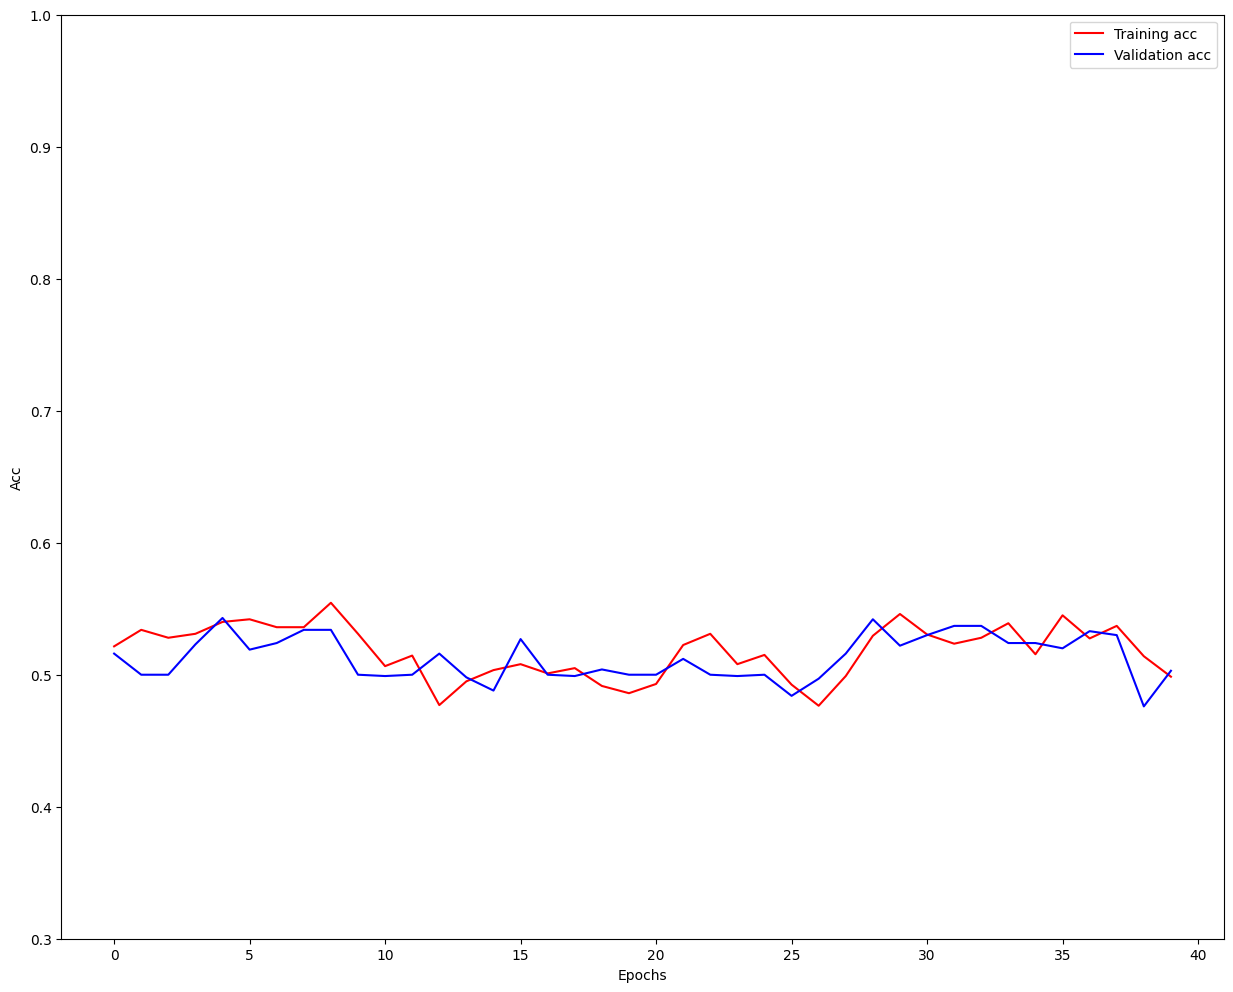

In [89]:
train_acc = df["accuracy"]
val_acc = df["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

The performance is not improving. Rather decreased significantly. It can happen as you have a very small dataset to train the model. Fine tuning it is changing to the weights to some undesired value. The original ImageNet weights are better fit for this type of data (Cat/dog images).

# Fine Tuning - V2

**Define some layers trainable**

In [90]:
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', # you can also perform random initialization of weights instead of using pretrained weights- check documentation
    input_shape=(224,224, 3),
    include_top=False)

https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

In [91]:
# defining certain layers as trainable (later portions). Top layers are performing feature extraction using pre-trained weights.
# Only the later layer weights are tuned for the particular dataset.

base_model.get_layer('block1_conv1').trainable = False
base_model.get_layer('block1_conv2').trainable = False

base_model.get_layer('block2_conv1').trainable = False
base_model.get_layer('block2_conv2').trainable = False

base_model.get_layer('block3_conv1').trainable = False
base_model.get_layer('block3_conv2').trainable = False
base_model.get_layer('block3_conv3').trainable = False

base_model.get_layer('block4_conv1').trainable = False
base_model.get_layer('block4_conv2').trainable = False
base_model.get_layer('block4_conv3').trainable = False

base_model.get_layer('block5_conv1').trainable = True
base_model.get_layer('block5_conv2').trainable = True
base_model.get_layer('block5_conv3').trainable = True

In [92]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [96]:
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented_data= data_augmentation(inputs)
x= tf.keras.applications.vgg16.preprocess_input(augmented_data)

x = base_model(x, training=True)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x= tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1)(x)

In [97]:
model = tf.keras.Model(inputs, outputs)

In [98]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_7  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_7 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0   

In [99]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [100]:
history_v4 = model.fit(training_set,
                          epochs=40,
                          validation_data= val_dataset,
                         )

Epoch 1/40
63/63 [==============================] - 8s 78ms/step - loss: 5.3965 - accuracy: 0.6335 - val_loss: 5.7240 - val_accuracy: 0.6240
Epoch 2/40
63/63 [==============================] - 5s 75ms/step - loss: 5.2720 - accuracy: 0.6485 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/40
63/63 [==============================] - 5s 74ms/step - loss: 6.1269 - accuracy: 0.5920 - val_loss: 6.5776 - val_accuracy: 0.5680
Epoch 4/40
63/63 [==============================] - 5s 75ms/step - loss: 5.4146 - accuracy: 0.6395 - val_loss: 5.9487 - val_accuracy: 0.6050
Epoch 5/40
63/63 [==============================] - 5s 75ms/step - loss: 6.0197 - accuracy: 0.6020 - val_loss: 5.3016 - val_accuracy: 0.6490
Epoch 6/40
63/63 [==============================] - 5s 75ms/step - loss: 5.5658 - accuracy: 0.6285 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 7/40
63/63 [==============================] - 5s 76ms/step - loss: 6.0102 - accuracy: 0.6000 - val_loss: 7.4809 - val_accuracy: 0.5150
Epoch 8/40
63

In [101]:
df = pd.DataFrame(history_v4.history)
df.tail(10)

,loss,accuracy,val_loss,val_accuracy
30,2.883234,0.8065,2.358777,0.843
31,2.998748,0.8000,2.856341,0.809
32,2.971819,0.8020,2.292334,0.848
33,3.044679,0.7970,7.401688,0.512
34,3.321995,0.7755,4.395440,0.709
35,3.001529,0.7995,2.128959,0.857
36,2.771886,0.8120,2.798070,0.815
37,2.580392,0.8295,2.054826,0.863
38,2.536511,0.8315,1.959411,0.869
39,2.691005,0.8205,2.068514,0.864


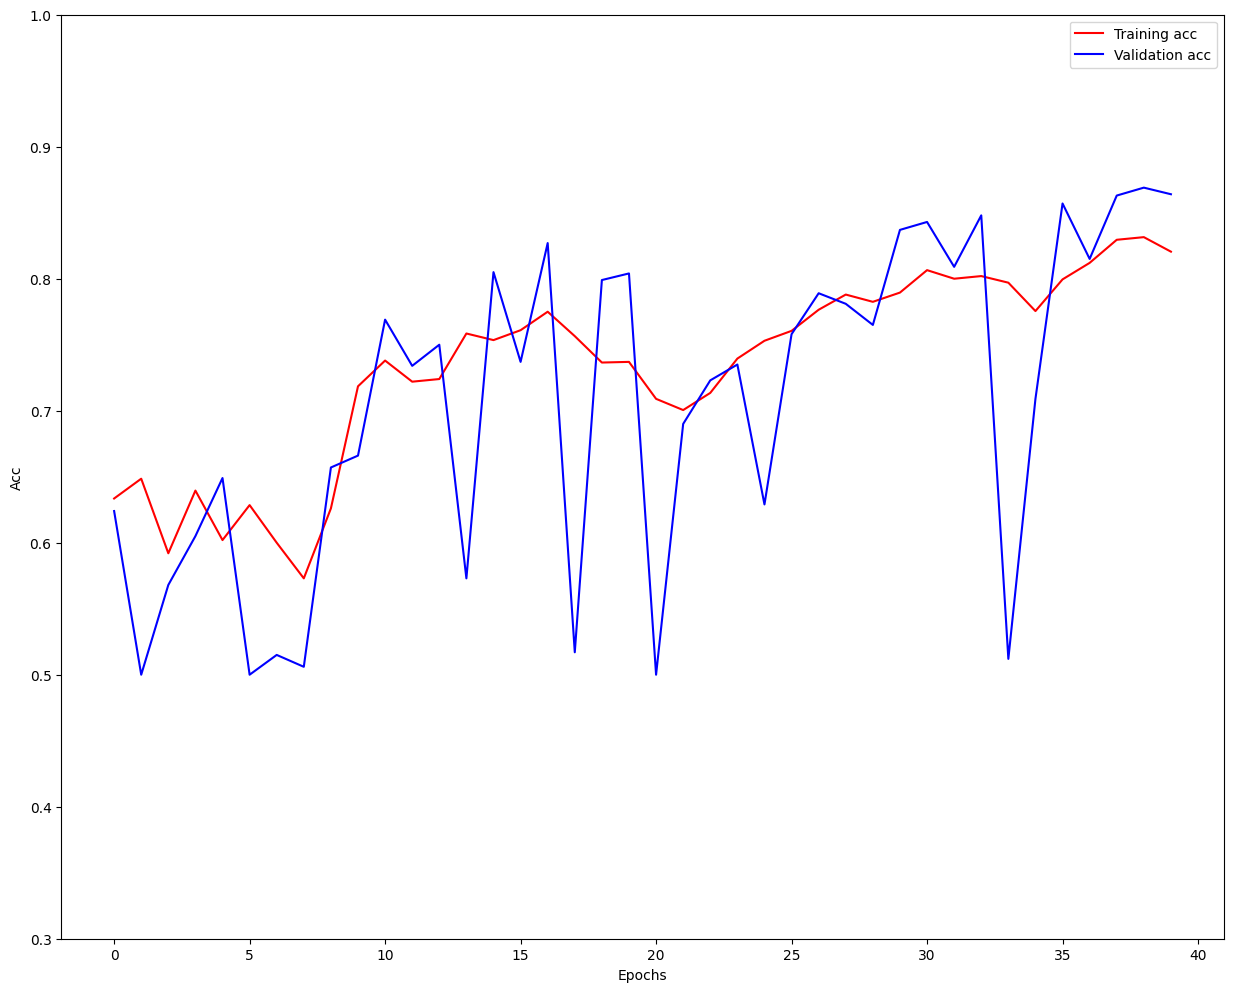

In [102]:
train_acc = df["accuracy"]
val_acc = df["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.3, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

Better than Fine tuning- V1, but less than original weights.

Test it on a different dataset (images that are not among the 1000 different categories of the ImageNet dataset).

Also test other pretrained models like Xception, Resnet, etc.